In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import os

%matplotlib inline
plt.style.use('ggplot')
mlp.rcParams['figure.figsize'] = [8.0, 8.0]

In [2]:
base_dir = "../../../../Outcome Measurement Data/MALARIA/Distribucion de MTILD/"

In [8]:
entregas = None
entregasDetalles = None
for year in [2015, 2016, 2017, 2018]:
    for (dirpath, dirnames, filenames) in os.walk(base_dir + "BD " + str(year) + "/"):
        for filename in filenames:
            if "EntregaPIIs." in filename:
                if (filename.endswith(".csv")):
                    temp = pd.read_csv(dirpath + "/" + filename)
                elif (filename.endswith(".xlsx")):
                    temp = pd.read_excel(dirpath + "/" + filename, 0)
                temp["bd_year"] = year
                if entregas is None:
                    entregas = temp
                else:
                    entregas = pd.concat([entregas, temp]) 
            elif "EntregaPIIsDetalle." in filename:
                if (filename.endswith(".csv")):
                    temp = pd.read_csv(dirpath + "/" + filename)
                elif (filename.endswith(".xlsx")):
                    temp = pd.read_excel(dirpath + "/" + filename, 0)
                temp["bd_year"] = year
                if entregasDetalles is None:
                    entregasDetalles = temp
                else:
                    entregasDetalles = pd.concat([entregasDetalles, temp]) 

In [9]:
entregas["year"] = pd.to_numeric(entregas.FechaEnt.astype(str)\
            .map(lambda x: (x[0:4] if x.startswith("201") else x[-4:])), errors= "coerce")
entregas["month"] = pd.to_numeric(entregas.FechaEnt.astype(str)\
            .map(lambda x: (x[5:7] if x.startswith("201") else x[-7:-5])), errors= "coerce")

In [10]:
entregas.month.value_counts(dropna=False)

 6.0     21429
 11.0    20715
 10.0    20076
 12.0    16650
 5.0     16251
 4.0     14816
 9.0     14422
 8.0     13125
 7.0     12311
 3.0      5159
 2.0      4445
 1.0      3853
NaN        124
Name: month, dtype: int64

In [11]:
entregas[(entregas.year == 2016) & (entregas.bd_year == 2016)].CodDepto.value_counts()

16.0    2546
17.0    1998
5.0     1424
18.0    1194
11.0    1131
12.0     975
14.0     775
6.0      558
9.0      522
19.0     449
21.0     362
10.0     138
7.0       85
22.0      74
13.0      46
4.0       14
Name: CodDepto, dtype: int64

In [12]:
entregas[(entregas.year == 2016) & (entregas.bd_year == 2017)].CodDepto.value_counts()

16.0    2546
17.0    1998
5.0     1424
18.0    1194
14.0     775
9.0      522
19.0     456
10.0     138
7.0       85
Name: CodDepto, dtype: int64

In [13]:
entregas.columns

Index(['Apellido', 'Apellido_2', 'AñoProy', 'Camas', 'Categoria', 'Categoría',
       'Cedula', 'CodBoleta', 'CodComun', 'CodDepto', 'CodMuni', 'CodReg',
       'FechaEnt', 'Firma', 'Huella', 'MEmbarazada', 'Menores5a', 'Nombre',
       'Nombre_2', 'OID_', 'Pabellones', 'Personas', 'ProyectoMalaria',
       'Responsable', 'Sustit', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'bd_year', 'lp', 'nomlp',
       'year', 'month'],
      dtype='object')

In [14]:
entregas_sub = entregas[((entregas.bd_year==2015) & (entregas.year <= 2015)) | 
                 ((entregas.bd_year==2016) & (entregas.year == 2016)) |
                 ((entregas.bd_year==2017) & (entregas.year == 2017)) ]

In [15]:
(entregas.year).value_counts().sort_index()

2012.0    42927
2013.0    12396
2014.0     9672
2015.0    58133
2016.0    29905
2017.0     5626
2018.0     4593
Name: year, dtype: int64

In [16]:
eMerge = pd.merge(entregas[["CodDepto", "CodComun", "CodBoleta", "bd_year", "FechaEnt", "year", "month"]], 
                  entregasDetalles[["CodDepto", "CodComun", "CodBoleta", "bd_year", 
                                    "Personas", "MEmbarazada", "Menores5a", "Camas", "Pabellones"]], 
                  how="inner", 
                  on=["CodComun", "CodBoleta", "bd_year"], suffixes=("_e", "_eD"))

In [17]:
eMerge.shape

(1588353, 13)

In [18]:
entregasDetalles.shape

(1530109, 30)

In [19]:
entregasDetalles.bd_year.value_counts()

2016    420840
2017    394937
2015    364985
2018    349347
Name: bd_year, dtype: int64

In [20]:
eMerge = eMerge[eMerge.year.isna() == False]

In [21]:
eMerge.groupby(["CodDepto_e", (eMerge.year*100+(eMerge.month/3).astype(int)*3)]).\
    Pabellones.sum().unstack(1).fillna(0)

,201200.0,201203.0,201206.0,201209.0,201212.0,201300.0,201303.0,201306.0,201309.0,201312.0,...,201612.0,201700.0,201703.0,201706.0,201709.0,201712.0,201800.0,201803.0,201806.0,201809.0
CodDepto_e,,,,,,,,,,,,,,,,,,,,,
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,530.0,139890.0,172510.0,2995.0,0.0,465.0,2155.0,4670.0,31525.0,24490.0,...,672.0,0.0,8714.0,18884.0,10852.0,1550.0,4310.0,12774.0,225.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3110.0,337.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5170.0,446.0,0.0,0.0,0.0,0.0,0.0,2100.0,1990.0,0.0
10.0,0.0,0.0,0.0,143106.0,48279.0,102204.0,37290.0,1989.0,840.0,42.0,...,20360.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0
11.0,0.0,0.0,4938.0,18003.0,6674.0,9680.0,13842.0,4790.0,0.0,0.0,...,6586.0,0.0,0.0,0.0,0.0,0.0,10631.0,11176.0,6130.0,0.0
12.0,0.0,0.0,7808.0,28698.0,2468.0,5350.0,7956.0,10816.0,14000.0,2760.0,...,2319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
deptos = gp.read_file("../../../../Covariates and Other Data/GIS/GT-IGN-cartografia_basica-Departamentos.geojson")
deptos = deptos[lambda x: x.CODIGO.astype(int) <= 2200]

Text(0.5,1,'Pabellones entregados entre 2012 y 2017 \n(en miles)')

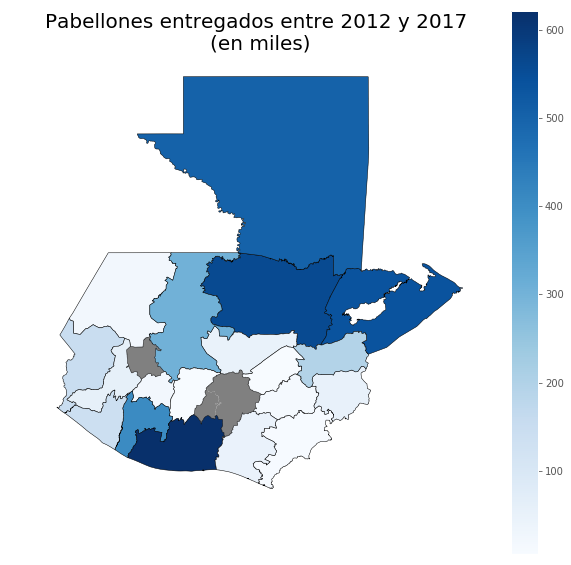

In [61]:
mlp.rcParams['figure.figsize'] = [10.0, 10.0]
mlp.rcParams['axes.titlesize'] = 20
temp = deptos.merge(eMerge.groupby("CodDepto_e").Pabellones.sum().divide(1000).reset_index()\
                         .assign(deptocode=lambda x: (x.CodDepto_e * 100).astype(int).astype(str)\
                                 .map(lambda y: y if y != 1 else "101")), 
                 left_on="CODIGO", right_on = "deptocode", how="outer" ).fillna(0)
ax = temp[temp.Pabellones == 0].plot(color="grey")
temp[temp.Pabellones > 0].plot("Pabellones", ax = ax, cmap = "Blues", legend=True, edgecolor="black")
ax.axis('off')
ax.set_title("Pabellones entregados entre 2012 y 2017 \n(en miles)")
    


In [65]:
pblYears = eMerge.groupby(["CodDepto_e", "year"]).Pabellones.sum().divide(1000).reset_index()\
                         .assign(deptocode=lambda x: (x.CodDepto_e * 100).astype(int).astype(str)\
                                 .map(lambda y: y if y != 1 else "101"))

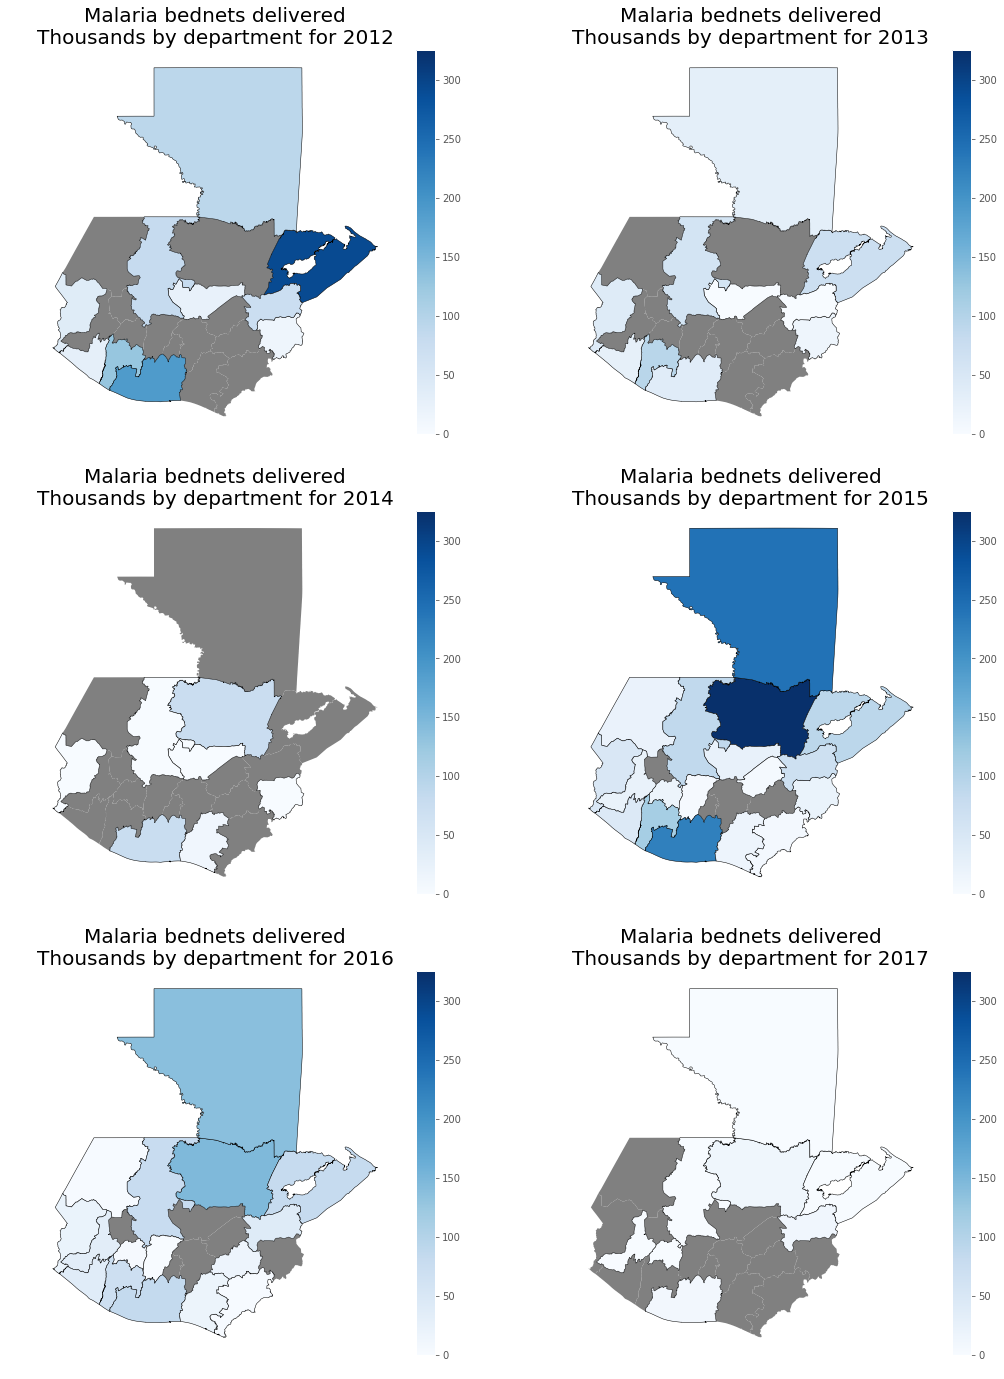

In [75]:
vmax = pblYears.Pabellones.max()

side = 8
n = 7
vmin = 0
#vmax = 8
f, axes = plt.subplots(int(np.ceil(n/2)), 2, figsize=(side*2*1.1, side*np.ceil(n/2) ))
i = 2012
for row in axes:
    for ax in row:
        temp3 = deptos.merge(pblYears[pblYears.year == i], 
                             left_on="CODIGO", right_on = "deptocode", how="left" ).fillna(0)
        temp3[temp3.Pabellones == 0].plot(ax=ax, color="grey")
        if len(temp3[temp3.Pabellones > 0])>0:
            temp3[temp3.Pabellones > 0].plot("Pabellones", ax = ax, cmap = "Blues", 
                                             legend=True, edgecolor="black",
                                             vmin = vmin, vmax = vmax)
        ax.axis('off')
        ax.set_title("Malaria bednets delivered\nThousands by department for "+ str(i))
        i += 1

In [77]:
eMerge.to_csv("../../../../Outcome Measurement Data/MALARIA/GTM - Bednets Distr.csv")